#### TODO:
- pct change instead of real values
- decomposition
- features

In [1]:
import os
import warnings
import multiprocessing

import torch
import numpy as np
import pandas as pd
import lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
torch.__version__

'2.0.1'

In [3]:
warnings.filterwarnings('ignore')

In [4]:
CPUS = (multiprocessing.cpu_count()//2) - 1
BATCH_SIZE = 64
N_STEPS_PAST = 7*24*2
HORIZON = 1*24*2

In [5]:
print(CPUS)

4


### Preparing Data

In [6]:
from st_forecasting.utils.functions import to_df, to_stream, denoise_by_square

In [7]:
data = pd.read_parquet('data/amman_data.pq').sort_values(['square_id', 'ts'])
pd_squares = pd.read_parquet('data/amman_squares.pq').assign(key=1)
ids = np.load('data/amman_squares.npy')

In [8]:
time = pd.DataFrame({'ts': pd.date_range(start=data['ts'].min(), end=data['ts'].max(), freq='30T')}).assign(key=1)
time['ts'] = time['ts'].astype(str)
time_squares = pd_squares.merge(time, on='key', how='outer').drop('key', axis=1).sort_values(['ts', 'square_id'])
data = time_squares.merge(data, on=['square_id', 'ts'], how='left')
data['intents'] = data['intents'].fillna(0)

In [9]:
denoised_df = denoise_by_square(data)

Denoising...: 100%|██████████████████████████| 324/324 [00:01<00:00, 256.63it/s]


In [10]:
stream = to_stream(data, pd_squares)
denoised_stream = to_stream(denoised_df, pd_squares)

Converting to stream...: 100%|█████████████| 8736/8736 [00:11<00:00, 784.72it/s]


### Splitting Data

In [11]:
all_indexes = list(range(N_STEPS_PAST+HORIZON, stream.shape[0]))

n = len(all_indexes)

train_indexes = all_indexes[:int(n*0.7)]
val_indexes = all_indexes[int(n*0.7):int(n*0.9)]
test_indexes = all_indexes[int(n*0.9):]

print(n)
print(len(train_indexes))
print(len(val_indexes))
print(len(test_indexes))

8352
5846
1670
836


### Scaler

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

train_ds = denoised_df[denoised_df['ts'] > time['ts'].values[train_indexes[-1]]]['intents'].values.reshape(-1, 1)

scaler.fit(train_ds)

StandardScaler()

### Training Data

In [37]:
from torch.utils.data import DataLoader

from st_forecasting.utils.dataset import GeoFramesDataset

In [38]:
train_dataset = GeoFramesDataset(
    x=denoised_stream,
    indexes=train_indexes,
    n_steps_past=N_STEPS_PAST,
    horizon=HORIZON,
    half=False,
    # scaler=scaler
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=CPUS
)

In [39]:
val_dataset = GeoFramesDataset(
    x=denoised_stream,
    indexes=val_indexes,
    n_steps_past=N_STEPS_PAST,
    horizon=HORIZON,
    half=False,
    # scaler=scaler
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=CPUS
)

In [40]:
train_loader.dataset[0][0].dtype

torch.float32

### Training

In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

from st_forecasting.custom_callbacks import progress_bar, MetricsCallback, checkpoint_callback
from st_forecasting.model import (
    ConvLSTMCell,
    ResNetLSTMCell,
    ConvLSTMNet,
    ConvGRUNet,
    ConvTTLSTMNet,
    ModelWrapper
)

In [42]:
backbone = ConvTTLSTMNet(
    input_channels=1,
    layers_per_block = (1), 
    hidden_channels  = (16),
    cell_params={'order': 3, 'steps': 6, 'ranks': 8},
    kernel_size=3,
    bias=True,
    teacher_forcing=False,
    scheduled_sampling_ratio=0 # 1e-3
)

In [43]:
optimizer = Adam(backbone.parameters(), lr=3e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=3)

pb = progress_bar()
ck = checkpoint_callback()

In [44]:
model = ModelWrapper(
    model=backbone,
    optimizer=optimizer,
    scheduler=scheduler,
    horizon=HORIZON,
    loss_fn_alias='rmse',
    loss_type='semi_masked',
    include_masked_metrics=True,
    masked_weight=0.3 #  only for semi-masked loss
)

mse will be used instead of rmse as basic loss function
mse will be used instead of rmse as masked loss function


In [45]:
trainer = pl.Trainer(
    default_root_dir='amman_convttlstm_logs',
    min_epochs=10,
    max_epochs=20,
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    callbacks=[pb, MetricsCallback(), ck]
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(
    model,
    train_loader,
    val_loader,
    # ckpt_path=''
)

┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ ConvTTLSTMNet │ 20.3 K │
└───┴───────┴───────────────┴────────┘

Trainable params: 20.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.3 K                                                                                               
Total estimated model params size (MB): 0

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

### Testing

In [47]:
test_dataset = GeoFramesDataset(
    x=denoised_stream,
    indexes=test_indexes,
    n_steps_past=N_STEPS_PAST,
    horizon=HORIZON,
    train=False,
    half=False,
    # scaler=scaler
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [48]:
preds = trainer.predict(model, test_loader, return_predictions=True, ckpt_path='best')

Restoring states from the checkpoint path at amman_convttlstm_logs/lightning_logs/version_0/checkpoints/epoch=4-step=460-v1.ckpt
Loaded model weights from the checkpoint at amman_convttlstm_logs/lightning_logs/version_0/checkpoints/epoch=4-step=460-v1.ckpt


Output()

In [49]:
np_preds = np.squeeze(np.concatenate([x.numpy() for x in preds]))

In [50]:
np_preds[0][3][9]

array([0.        , 0.        , 0.        , 0.05425352, 3.2477117 ,
       2.9222007 , 1.0355247 , 4.204672  , 1.0508527 , 0.05043042,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

### Analysis

In [51]:
def draw_series(data, denoised, preds, timesteps, ids, sample_i, sid): 
    y_hat = preds[sample_i]
    tss = timesteps[sample_i:sample_i+N_STEPS_PAST+HORIZON]
    
    sub_df = data[(data.square_id == sid) & (data['ts'].isin(tss))]
    sub_df['type'] = 'true'
    
    d_sub_df = denoised[(denoised.square_id == sid) & (denoised['ts'].isin(tss))]
    d_sub_df['type'] = 'denoised'
    
    df_list = []

    for i, ts in enumerate(timesteps[sample_i+N_STEPS_PAST:sample_i+N_STEPS_PAST+HORIZON]):
        sub = pd.DataFrame({'square_id': ids.flatten(), 'intents': y_hat[i].flatten()})
        sub['ts'] = ts
        df_list.append(sub)

    pred_df = pd.concat(df_list, ignore_index=True)
    pred_df = pred_df[pred_df.square_id == sid]
    pred_df['type'] = 'pred'
    
    df = pd.concat([
        sub_df.iloc[-(HORIZON+24*4):], 
        d_sub_df.iloc[-(HORIZON+24*4):], 
        pred_df.iloc[-(HORIZON+24*4):]  
    ]) 
    
    df['ts'] = df['ts'].astype(str)
    
    plt.figure(figsize=(20, 6))
    sns.lineplot(df, x='ts', y='intents', hue='type')
    plt.xticks(fontsize=4, rotation=90)
    plt.title(f'Timeline for square {sid}')

In [52]:
tt = time['ts'].values[test_indexes[0]-HORIZON:]
test_data = data[data['ts'] >= tt[0]].copy()
test_den_data = denoised_df[denoised_df['ts'] >= tt[0]].copy()

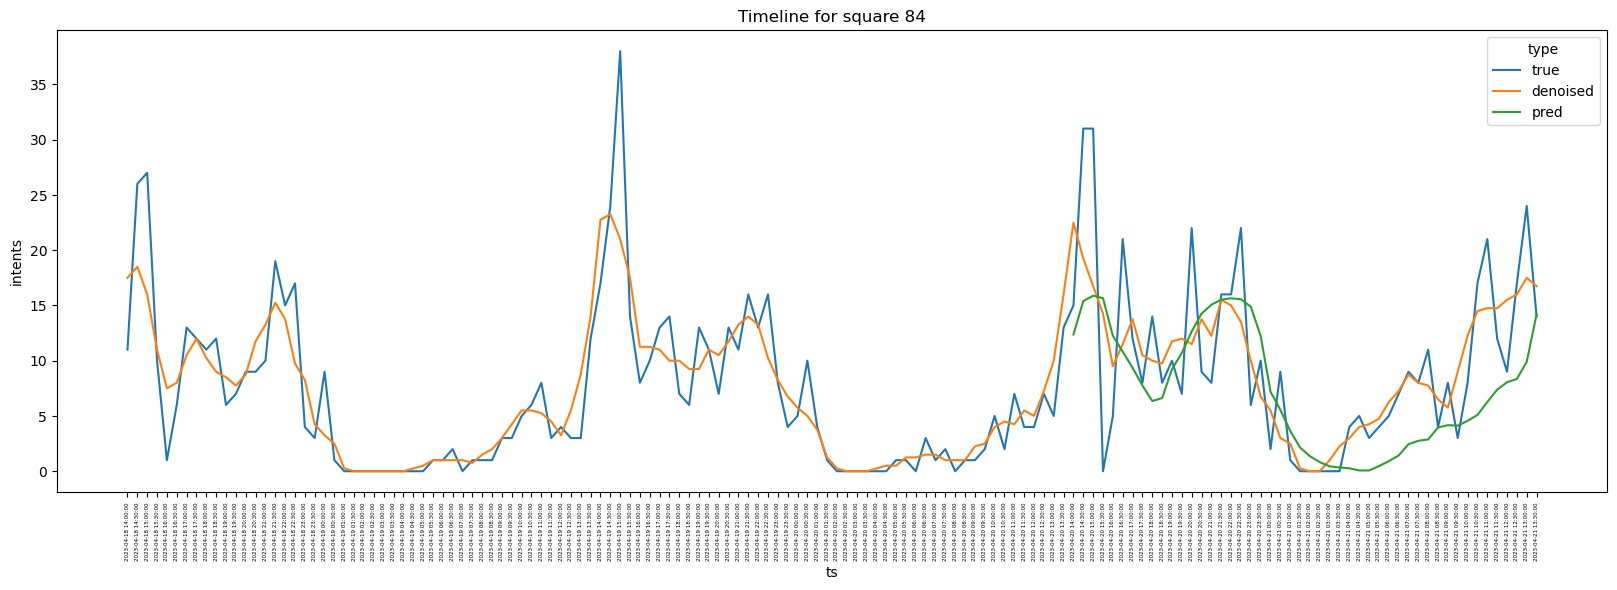

In [53]:
draw_series(test_data, test_den_data, np_preds, tt, ids, 0, 84)

##### Aggregated

In [59]:
INDEX = 0

f = np_preds[INDEX]
f = np.array([np.round(x).sum() for x in f])

start_tt = time['ts'].values[test_indexes[INDEX]+INDEX+N_STEPS_PAST:test_indexes[INDEX]+INDEX+N_STEPS_PAST+HORIZON]

data_agg = data[data['ts'].isin(start_tt)].copy()
data_agg = data_agg[['ts', 'intents']].groupby('ts', as_index=False).sum()
data_agg['type'] = 'true'

ddata_agg = denoised_df[denoised_df['ts'].isin(start_tt)].copy()
ddata_agg = ddata_agg[['ts', 'intents']].groupby('ts', as_index=False).sum()
ddata_agg['type'] = 'denoised'

preds_agg = pd.DataFrame({'ts': start_tt, 'intents': f})
preds_agg['type'] = 'pred'

agg = pd.concat([data_agg, ddata_agg, preds_agg], ignore_index=True)

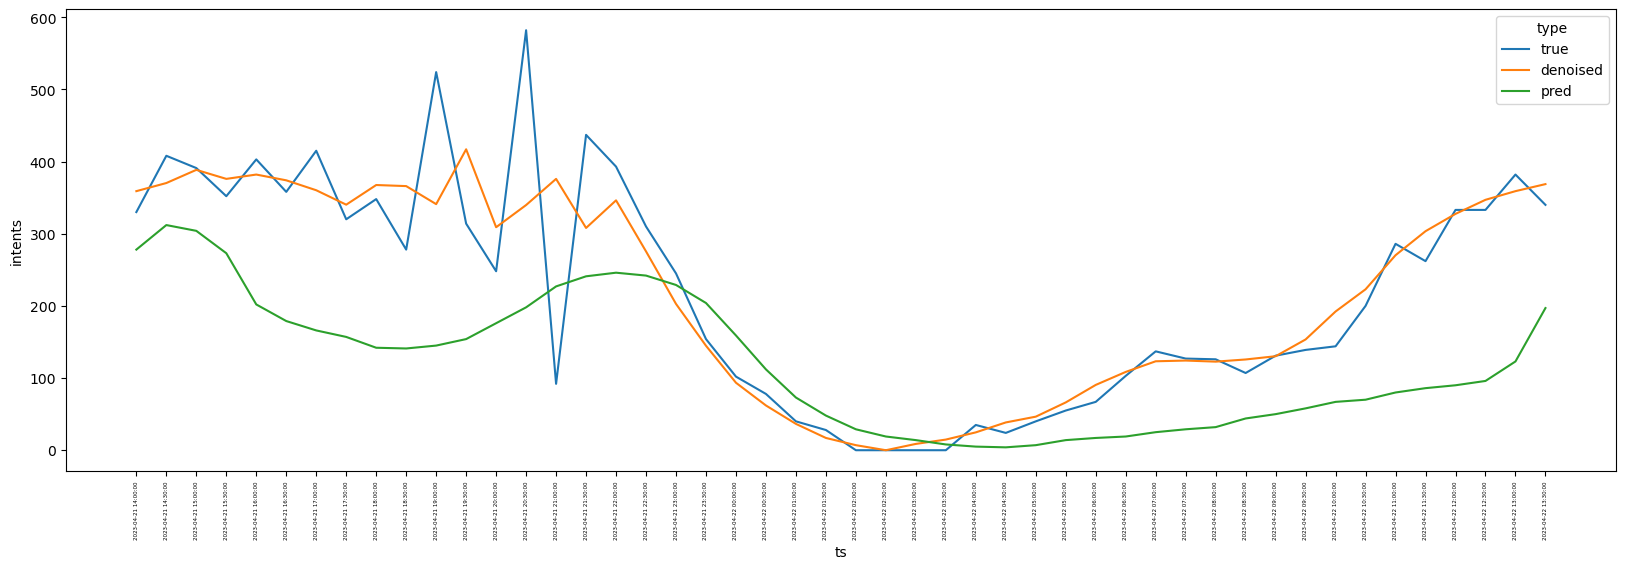

In [60]:
plt.figure(figsize=(20, 6))
sns.lineplot(agg, x='ts', y='intents', hue='type')
plt.xticks(fontsize=4, rotation=90)
plt.show()